In [1]:
import yfinance
import mplfinance as mpf
import matplotlib. pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from stockstats import StockDataFrame
from statsmodels.tsa.stattools import adfuller
from typing import Tuple

# Download Data

In [2]:
data = yfinance.download(
            tickers=['AAPL'],
            start='2021-01-01',
            end=None,
            interval='1d',
            auto_adjust=True,
            prepost=False
        )

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

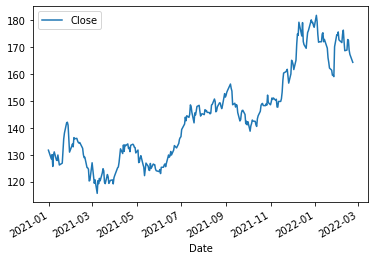

In [3]:
data[['Close']].plot()

In [4]:
# Compute technical indicators
TECHNICAL_INDICATORS = ['macd', 'macds', 'rsi_30', 'rsi_12', 'rsi_26']
stock = StockDataFrame.retype(data.copy())
for technical_indicator_name in TECHNICAL_INDICATORS:
    oscillator_data = stock[technical_indicator_name]
    data[technical_indicator_name] = oscillator_data
data = data.bfill(axis='rows')

In [5]:
data.head()

,Open,High,Low,Close,Volume,macd,macds,rsi_30,rsi_12,rsi_26
Date,,,,,,,,,,
2020-12-31,133.088923,133.744048,130.746367,131.709198,99116600,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,132.533066,132.622397,125.823032,128.453445,143301900,-0.073046,-0.040581,0.000000,0.000000,0.000000
2021-01-05,127.937286,130.766226,127.480679,130.041611,97664900,-0.043826,-0.041911,33.538196,34.732176,33.656864
2021-01-06,126.775931,130.081319,125.445832,125.664207,155088000,-0.187506,-0.091232,17.143887,16.989442,17.130102
2021-01-07,127.411211,130.657044,126.914907,129.952286,109578200,-0.091000,-0.091163,44.591273,46.303207,44.762884


In [6]:
data.tail()

,Open,High,Low,Close,Volume,macd,macds,rsi_30,rsi_12,rsi_26
Date,,,,,,,,,,
2022-02-15,170.970001,172.949997,170.250000,172.789993,64286300,0.529769,0.393739,53.741292,53.614585,53.495664
2022-02-16,171.850006,173.339996,170.050003,172.550003,61177400,0.589179,0.432827,53.545029,53.128543,53.272299
2022-02-17,171.029999,171.910004,168.470001,168.880005,69589300,0.336248,0.413511,50.620533,46.149182,49.955030
2022-02-18,169.820007,170.539993,166.190002,167.300003,82614200,0.008210,0.332451,49.418445,43.467352,48.600025
2022-02-22,164.979996,166.690002,162.149994,164.320007,91004600,-0.486613,0.168638,47.230131,38.825121,46.144884


# Bring Prices & Volume to Log Scale

In [7]:
data[['Open', 'High', 'Low', 'Close', 'Volume']] = data[['Open', 'High', 'Low', 'Close', 'Volume']].apply(np.log)
data.head()

,Open,High,Low,Close,Volume,macd,macds,rsi_30,rsi_12,rsi_26
Date,,,,,,,,,,
2020-12-31,4.891017,4.895928,4.873259,4.880596,18.411807,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,4.886832,4.887506,4.834876,4.855567,18.780464,-0.073046,-0.040581,0.000000,0.000000,0.000000
2021-01-05,4.851540,4.873411,4.847965,4.867854,18.397053,-0.043826,-0.041911,33.538196,34.732176,33.656864
2021-01-06,4.842421,4.868160,4.831874,4.833613,18.859503,-0.187506,-0.091232,17.143887,16.989442,17.130102
2021-01-07,4.847420,4.872576,4.843517,4.867167,18.512149,-0.091000,-0.091163,44.591273,46.303207,44.762884


In [8]:
data.tail()

,Open,High,Low,Close,Volume,macd,macds,rsi_30,rsi_12,rsi_26
Date,,,,,,,,,,
2022-02-15,5.141488,5.153003,5.137268,5.152077,17.978857,0.529769,0.393739,53.741292,53.614585,53.495664
2022-02-16,5.146622,5.155255,5.136093,5.150687,17.929288,0.589179,0.432827,53.545029,53.128543,53.272299
2022-02-17,5.141839,5.146971,5.126758,5.129188,18.058121,0.336248,0.413511,50.620533,46.149182,49.955030
2022-02-18,5.134739,5.138970,5.113132,5.119789,18.229692,0.008210,0.332451,49.418445,43.467352,48.600025
2022-02-22,5.105824,5.116136,5.088522,5.101816,18.326421,-0.486613,0.168638,47.230131,38.825121,46.144884


# Compute Weights Functions

In [9]:
def get_weights(d: int, thres: float) -> np.ndarray:
    w, k = [1.], 1
    
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        
    return np.array(w[::-1]).reshape(-1, 1)



def get_fixed_weights(d: float, size: int) -> np.ndarray:
    w = [1.]
    
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    
    return w



def plot_weights(d_range: list, n_plots: int, size: int) -> None:
    if len(d_range) == 1:
        d_values = d_range
    else:
        d_values = np.linspace(d_range[0], d_range[1], n_plots)
        
    w = pd.DataFrame()
    for d in d_values:
        w_ = get_fixed_weights(d, size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
        
    ax = w.plot()
    ax.legend(loc='upper left')
    ax.set_xlabel('K = Number of Observations')
    ax.set_ylabel('W = Weights')
    plt.show()

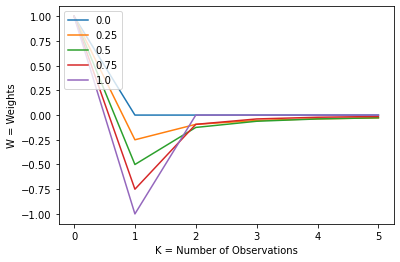

In [10]:
plot_weights(d_range=[0, 1], n_plots=5, size=6)

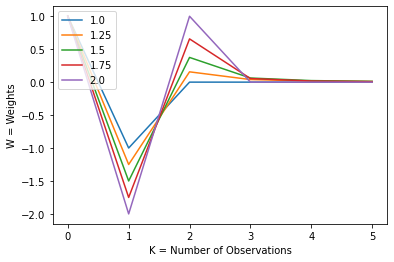

In [11]:
plot_weights(d_range=[1, 2], n_plots=5, size=6)

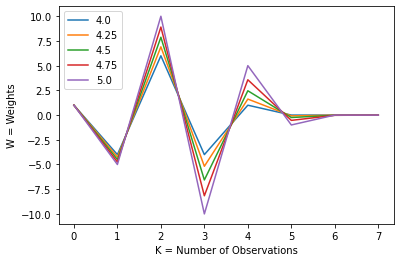

In [12]:
plot_weights(d_range=[4, 5], n_plots=5, size=8)

# Apply Weights to Time Series

In [13]:
def frac_diff(data: pd.DataFrame, d: float, thres=1e-3) -> Tuple[pd.DataFrame, np.ndarray]:
    # Constant width window
    w = get_weights(d, thres)
    width = len(w) - 1
    
    df = {}
    for name in data.columns:
        column_data = data[[name]].fillna(method='ffill').dropna()
        differentiated_column_data = pd.Series(dtype=np.float32)
        for end_iloc in range(width, column_data.shape[0]):
            start_loc = column_data.index[end_iloc - width]
            end_loc = column_data.index[end_iloc]
            if not np.isfinite(data.loc[end_loc, name]):
                # Exclude NaNs
                continue
            differentiated_column_data[end_loc] = np.dot(w.T, column_data.loc[start_loc:end_loc]).item()
        df[name] = differentiated_column_data.copy(deep=True)
    df = pd.concat(df, axis=1)
    
    return df, w


def frac_diff_fixed(data: pd.DataFrame, d: float, size: int) -> Tuple[pd.DataFrame, np.ndarray]:
    # Constant width window
    w = get_fixed_weights(d, size)
    width = len(w) - 1
    
    df = {}
    for name in data.columns:
        column_data = data[[name]].fillna(method='ffill').dropna()
        differentiated_column_data = pd.Series(dtype=np.float32)
        for end_iloc in range(width, column_data.shape[0]):
            start_loc = column_data.index[end_iloc - width]
            end_loc = column_data.index[end_iloc]
            if not np.isfinite(data.loc[end_loc, name]):
                # Exclude NaNs
                continue
            differentiated_column_data[end_loc] = np.dot(w.T, column_data.loc[start_loc:end_loc]).item()
        df[name] = differentiated_column_data.copy(deep=True)
    df = pd.concat(df, axis=1)
    
    return df, w


def search_parameters(data: pd.DataFrame) -> pd.DataFrame:
    parameters = pd.DataFrame(columns=['ADF value', 'p value', 'lags', 'nObs', '95% conf', 'corr'])
    for d in np.linspace(0, 1, 11):
        df1 = data[['Close']].resample('1D').last()
        df2, _ = frac_diff_fixed(df1, d, size=5)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        
        parameters.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    
    ax = parameters[['ADF value', 'corr']].plot(secondary_y='ADF value')
    ax.set_xlabel('d value')
    ax.set_ylabel('correlation')
    plt.axhline(parameters['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    
    d_value = find_d_value(parameters)
    if d_value is not None:
        plt.axvline(d_value, linewidth=1, color='g', linestyle='dotted')
    
    return parameters, d_value


def find_d_value(parameters: pd.DataFrame) -> float:
    conf_95 = parameters['95% conf'].mean()
    for d_value, row in parameters.iterrows():
        if row['ADF value'] <= conf_95:
            return d_value
        
    return None

In [14]:
data_frac_diff = data.copy()


Possible parameters
     ADF value       p value  lags   nObs  95% conf      corr
0.0  -1.038551  7.389454e-01   1.0  285.0 -2.871735  1.000000
0.1  -1.223987  6.631929e-01   1.0  285.0 -2.871735  0.999340
0.2  -1.509888  5.286144e-01   1.0  285.0 -2.871735  0.996513
0.3  -1.921208  3.221509e-01   1.0  285.0 -2.871735  0.989312
0.4  -2.505319  1.141856e-01   1.0  285.0 -2.871735  0.973263
0.5  -3.344186  1.301523e-02   1.0  285.0 -2.871735  0.939335
0.6  -4.566877  1.485989e-04   1.0  285.0 -2.871735  0.870556
0.7  -6.332543  2.882652e-08   1.0  285.0 -2.871735  0.742055
0.8  -8.653210  5.049584e-14   1.0  285.0 -2.871735  0.539969
0.9 -10.915488  1.070191e-19   1.0  285.0 -2.871735  0.297630
1.0 -12.066251  2.404949e-22   1.0  285.0 -2.871735  0.080813
d_value: 0.5


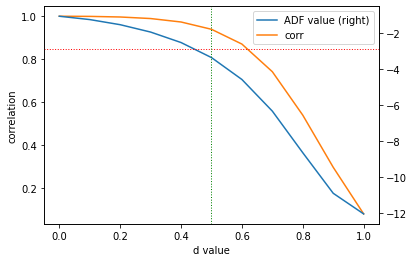

In [15]:
parameters, d_value = search_parameters(data_frac_diff)
print('\nPossible parameters')
print(parameters)
print(f'd_value: {d_value}')

In [16]:
data_frac_diff, w_frac_diff = frac_diff(data_frac_diff, d_value)
# If d_value = 0.5 it is considered the classic integer differentiation method.
data_integer_diff, w_interger_diff = frac_diff(data_frac_diff, 1)

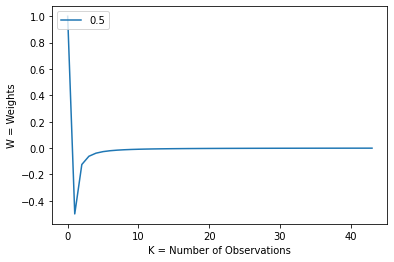

[[-0.00100927]
 [-0.00104575]
 [-0.00108449]
 [-0.00112567]
 [-0.00116953]
 [-0.00121631]
 [-0.00126629]
 [-0.0013198 ]
 [-0.00137718]
 [-0.00143885]]


In [17]:
plot_weights(d_range=[d_value], n_plots=1, size=len(w_frac_diff))
print(w_frac_diff[:10])

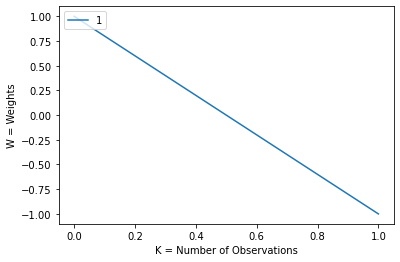

In [18]:
plot_weights(d_range=[1], n_plots=1, size=len(w_interger_diff))

### Let's See How the Prices & Volume Are Looking

<AxesSubplot:xlabel='Date'>

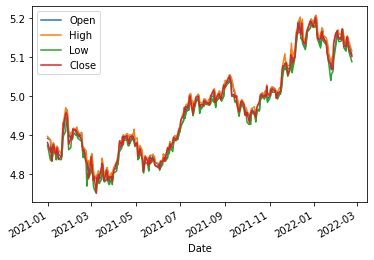

In [19]:
data[['Open', 'High', 'Low', 'Close']].plot()

<AxesSubplot:>

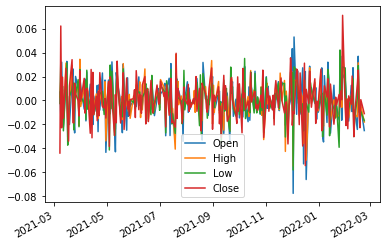

In [20]:
data_integer_diff[['Open', 'High', 'Low', 'Close']].plot()

We can see that the classic method of integer differentiation is almost flat & very sensitive to outliers.

<AxesSubplot:>

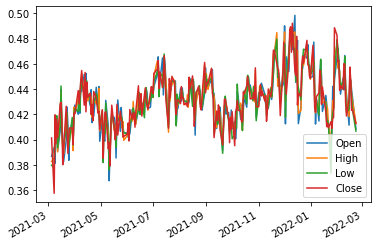

In [21]:
data_frac_diff[['Open', 'High', 'Low', 'Close']].plot()

We can definetly see that the mean & variance is almost the same for any random slice of the time series. 

<AxesSubplot:xlabel='Date'>

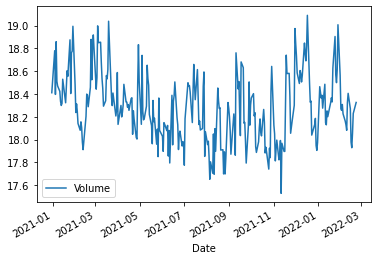

In [22]:
data[['Volume']].plot()

<AxesSubplot:>

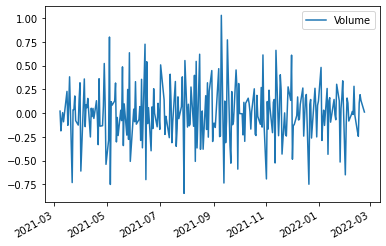

In [23]:
data_integer_diff[['Volume']].plot()

<AxesSubplot:>

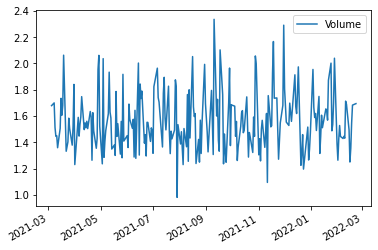

In [24]:
data_frac_diff[['Volume']].plot()

### Let's See How the Technical Indicators Are Looking

<AxesSubplot:xlabel='Date'>

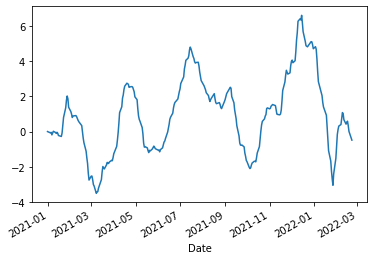

In [25]:
data['macd'].plot()

<AxesSubplot:>

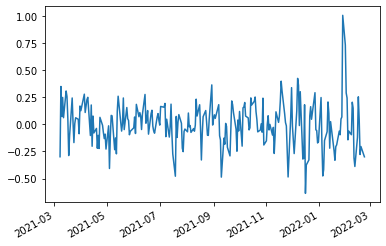

In [26]:
data_integer_diff['macd'].plot()

<AxesSubplot:>

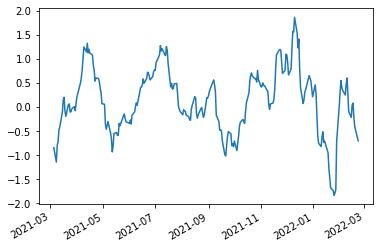

In [27]:
data_frac_diff['macd'].plot()

<AxesSubplot:xlabel='Date'>

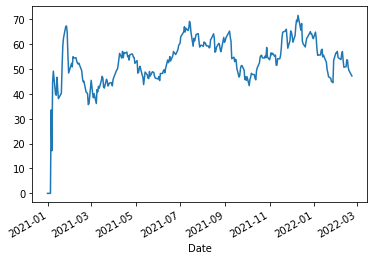

In [28]:
data['rsi_30'].plot()

<AxesSubplot:>

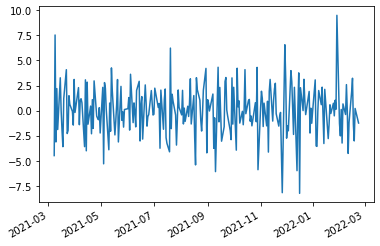

In [29]:
data_integer_diff['rsi_30'].plot()

<AxesSubplot:>

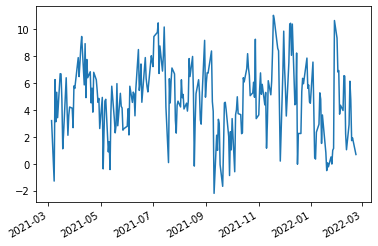

In [30]:
data_frac_diff['rsi_30'].plot()

# Visualize Correlations

In [53]:
def get_correlation(data: pd.DataFrame, d: float) -> float:
    frac_diff_data, _ = frac_diff_fixed(data, d, size=5)
    data = data.loc[frac_diff_data.index]
    corr = np.corrcoef(data['Close'], frac_diff_data['Close'])[0, 1]
    
    return corr

In [54]:
corr_frac_diff = get_correlation(data, d=0.5)
print(corr_frac_diff)

0.9383698988136451


In [55]:
corr_integer_diff = get_correlation(data, d=1.)
print(corr_integer_diff)

0.07046983987158252
